# Using Landlab and PyGMT Together to Create Interactive Erosion Slider

As we have seen, we can use Landlab and PyGMT together to download data, convert to and from PyGMT to Landlab, and  visualize our output using PyGMT plotting functions. Expanding on our usage of Landlab and PyGMT, in this tutorial we will explore:

- PyGMT Visualizations:
    - Digital Elevation Model (DEM) data visualized with ``grdimage`` for realistic mapping.
    
- Flow Path Overlay:
    - Threshold-based flow path extraction, visualized with <code>pygmt.plot</code>.
    
- Interactive Modeling:
    - Users can adjust the erodibility factor (K_sp) and observe terrain evolution with PyGMT maps.

## Required packages:
- Numpy
- PyGMT
- Landlab
- xarray
- ipywidgets

We will begin by importing the following packages

In [11]:
import numpy as np
import pygmt
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, DepressionFinderAndRouter
import xarray as xr
from ipywidgets import interact, FloatSlider

We will begin by loading in DEM data from PyGMT. Then using the size of this data to define the measurements of our grid. After, we will use the <code>RasterModelGrid</code> function from Landlab to create our grid.

In [82]:
#Load elevation data
lon_min, lon_max, lat_min, lat_max = -110, -80, 30, 50

grid = pygmt.datasets.load_earth_relief(resolution="01d", region=[lon_min, lon_max, lat_min, lat_max])

#Get the elevation data as a NumPy array
z = grid.data

#Update nrows and ncols based on the actual shape of z
nrows, ncols = z.shape

#Create a new RasterModelGrid with the correct dimensions
mg = RasterModelGrid((nrows, ncols), xy_spacing=grid.lon.values[1] - grid.lon.values[0]) # Use grid spacing from the loaded data

#Add the 'topographic__elevation' field to the grid
mg.add_field("node", "topographic__elevation", z.flatten(), units='-') # Adding the field and specifying units
mg.at_node['topographic__elevation'][:] = z.flatten()

<ipython-input-82-e5f75c3f6ed9>:16: FutureWarning: Calling `add_field` with the field location as the first argument is deprecated and will be removed in future versions. Instead, please use the `at` keyword to specify the location: add_field(arg0, arg1, at='node').
  mg.add_field("node", "topographic__elevation", z.flatten(), units='-') # Adding the field and specifying units


At first, we must convert our data from a Numpy array to xarray.DataArray which is what PyGMT uses. We can then visualize this data by using <code>Figure</code> and <code>grdimage</code>

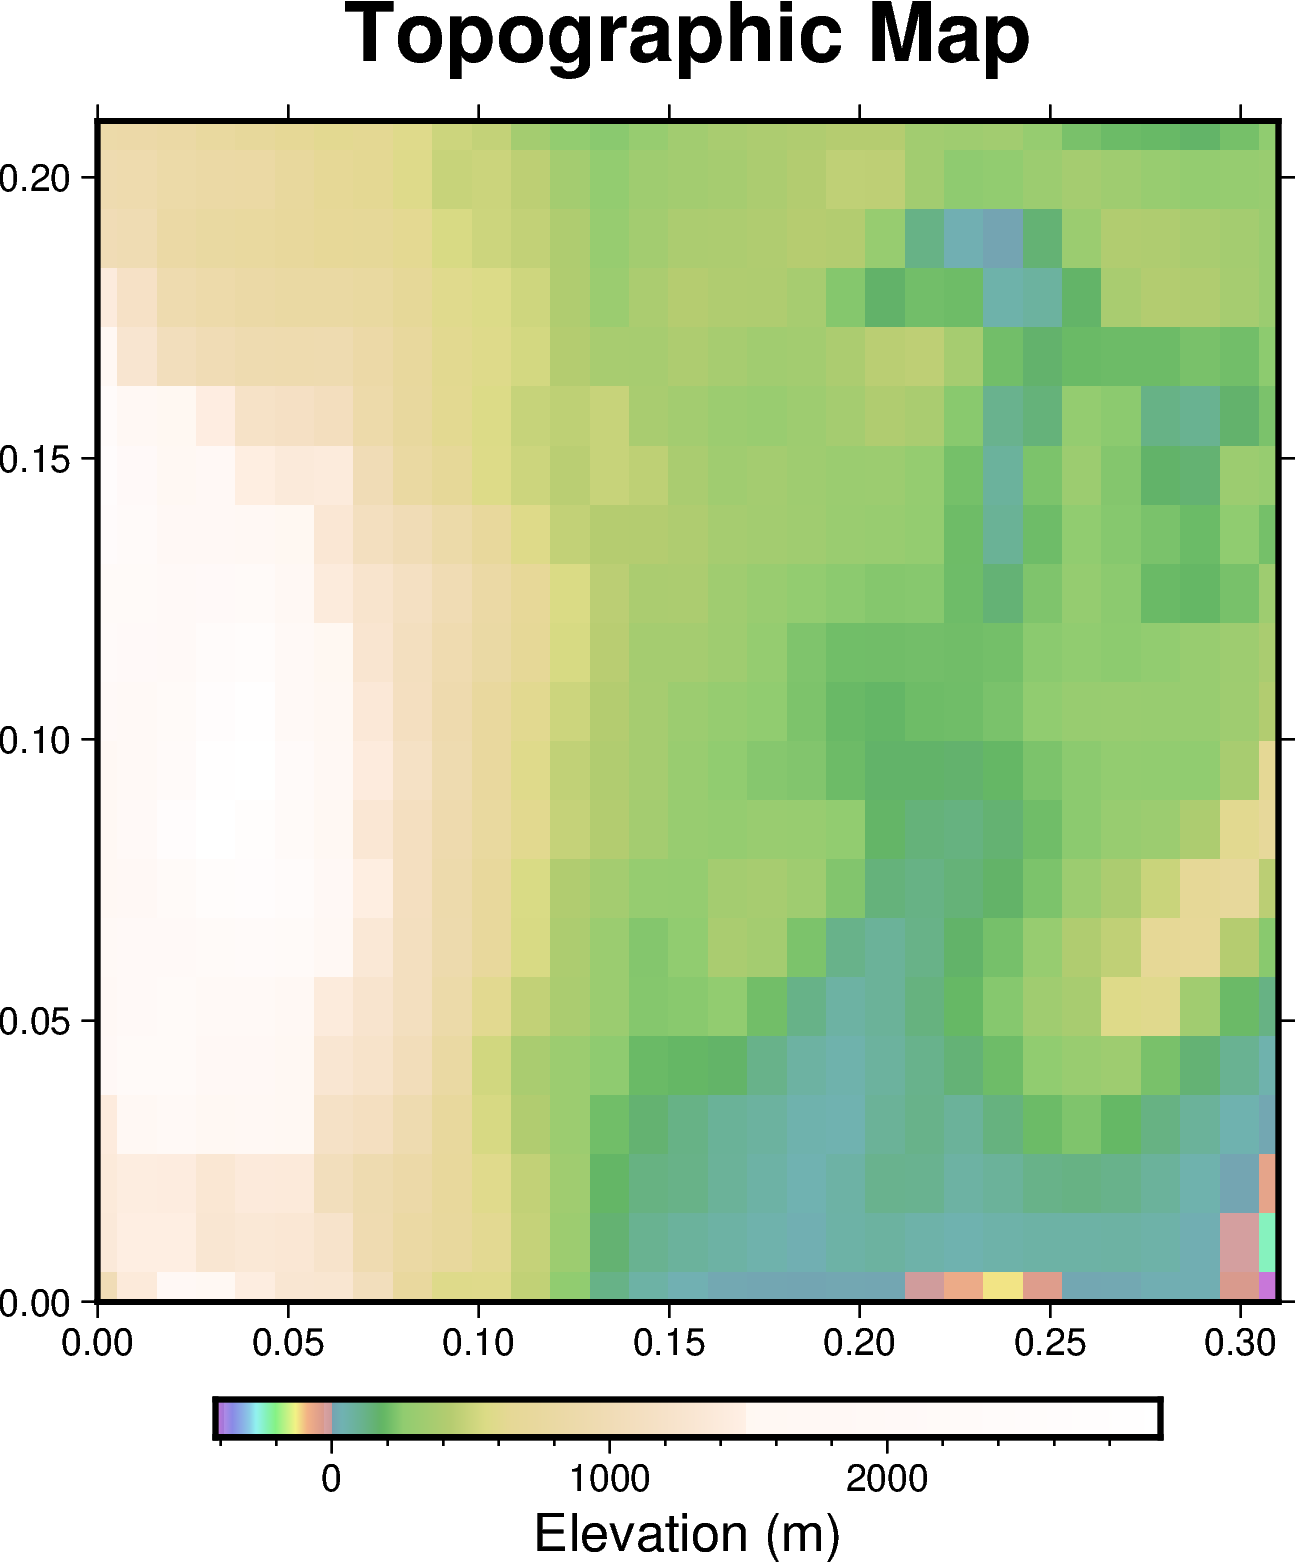

In [89]:
#Define minimum and maximum latitude and longitude for our region
region = [0, z.shape[1] * dx, 0, z.shape[0] * dx]
#Convert numpy array to xarray.DataArray with coordinates
grid = xr.DataArray(
    z,
    coords={
        "lon": np.linspace(region[0], region[1], z.shape[1]),
        "lat": np.linspace(region[2], region[3], z.shape[0])
    },
    dims=["lat", "lon"],
)

#Create a figure and plot the grid
fig = pygmt.Figure()
fig.grdimage(
    grid=grid,
    region=region,
    projection="X10c/10c",
    cmap="topo",
    frame=["a", "WSen+tTopographic Map"]
)
fig.colorbar(frame="af+lElevation (m)")
fig.show()

Next, we will create the elements we need to visualize the drainage area

In [84]:
#Initialize flow routing and depression filling
fa = FlowAccumulator(mg)
df = DepressionFinderAndRouter(mg)

#Run flow routing and depression filling
fa.run_one_step()
df.map_depressions()

#Ensure 'drainage_area' is present
drainage_area = mg.at_node["drainage_area"]

Now, visualizing drainage area

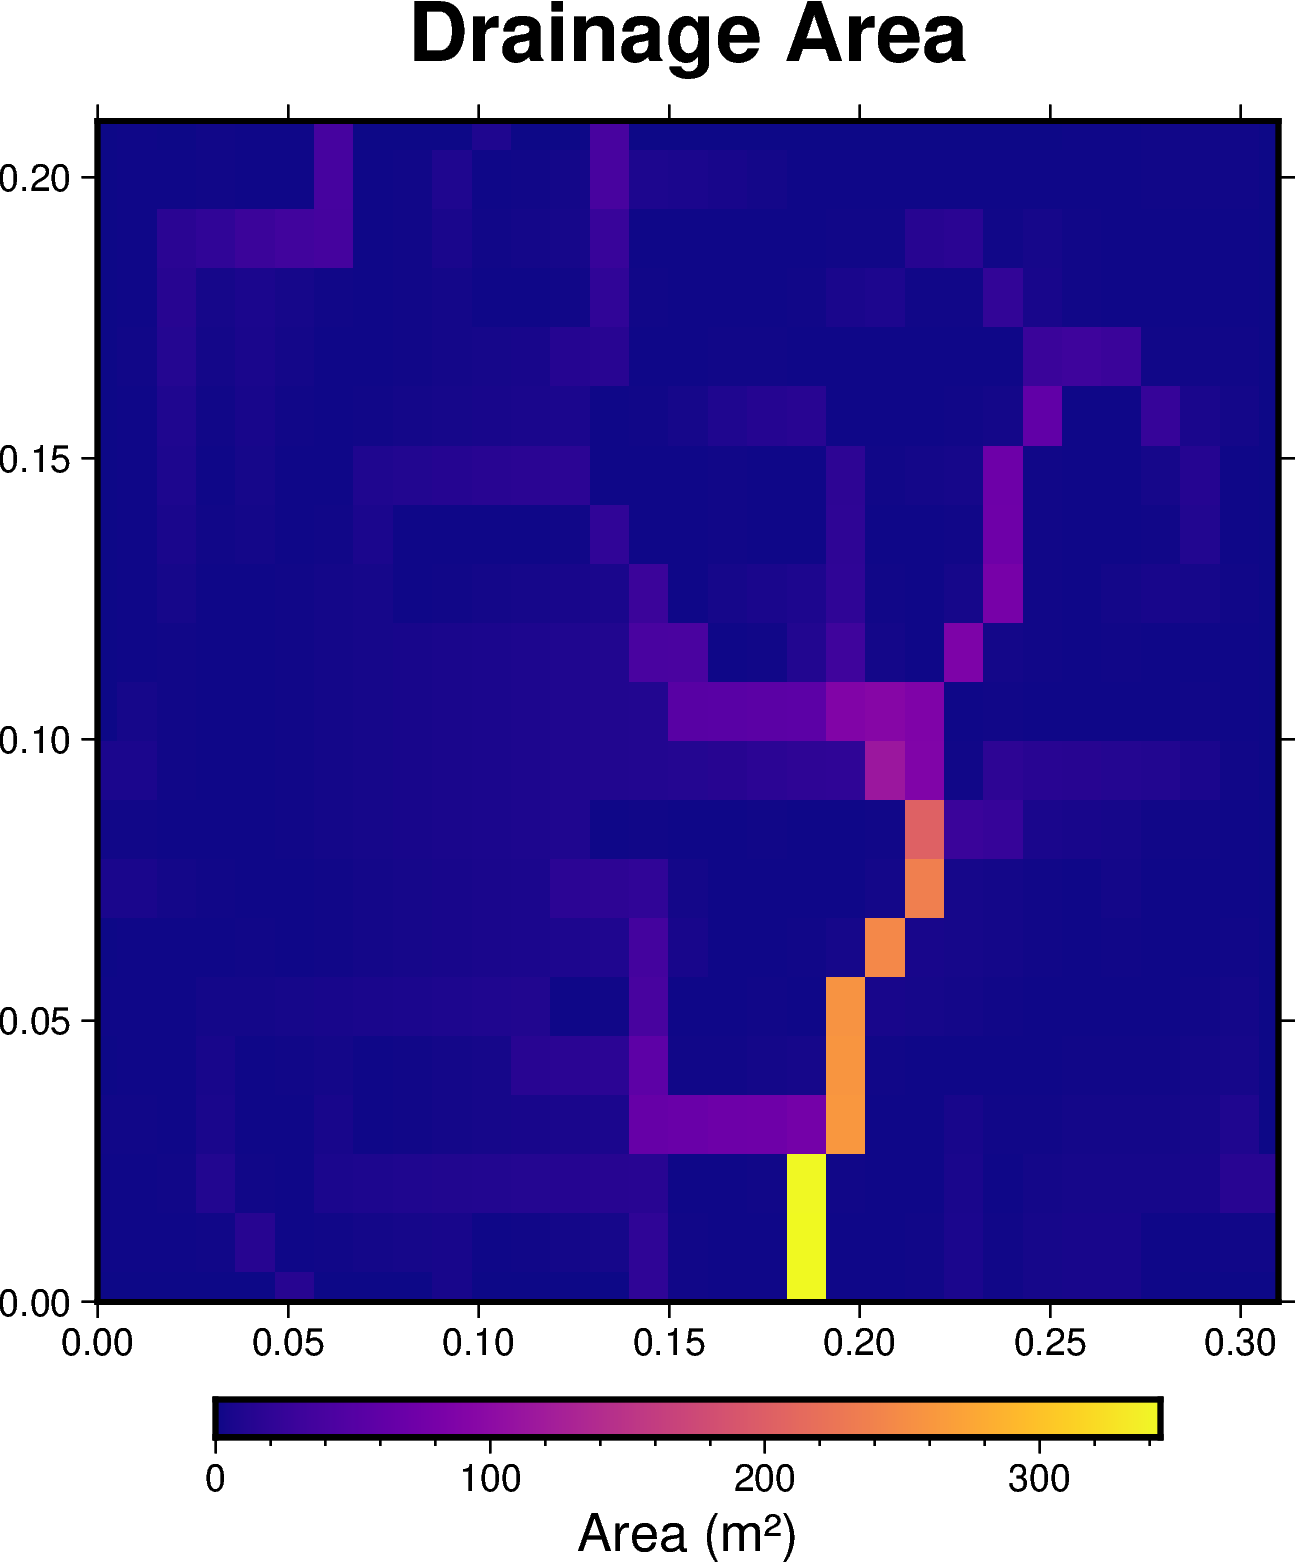

In [85]:
#Reshape drainage area and convert to xarray.DataArray
drainage_area_grid = xr.DataArray(
    drainage_area.reshape((nrows, ncols)),
    coords={
        "lon": np.linspace(region[0], region[1], ncols),
        "lat": np.linspace(region[2], region[3], nrows),
    },
    dims=["lat", "lon"],
)

#Visualize drainage area
fig = pygmt.Figure()
fig.grdimage(
    grid=drainage_area_grid,
    region=region,
    projection="X10c/10c",
    cmap="plasma",
    frame=["a", "WSen+tDrainage Area"]
)
fig.colorbar(frame="af+lArea (m²)")
fig.show()

Visualizing our erosion flow paths and our topographic map

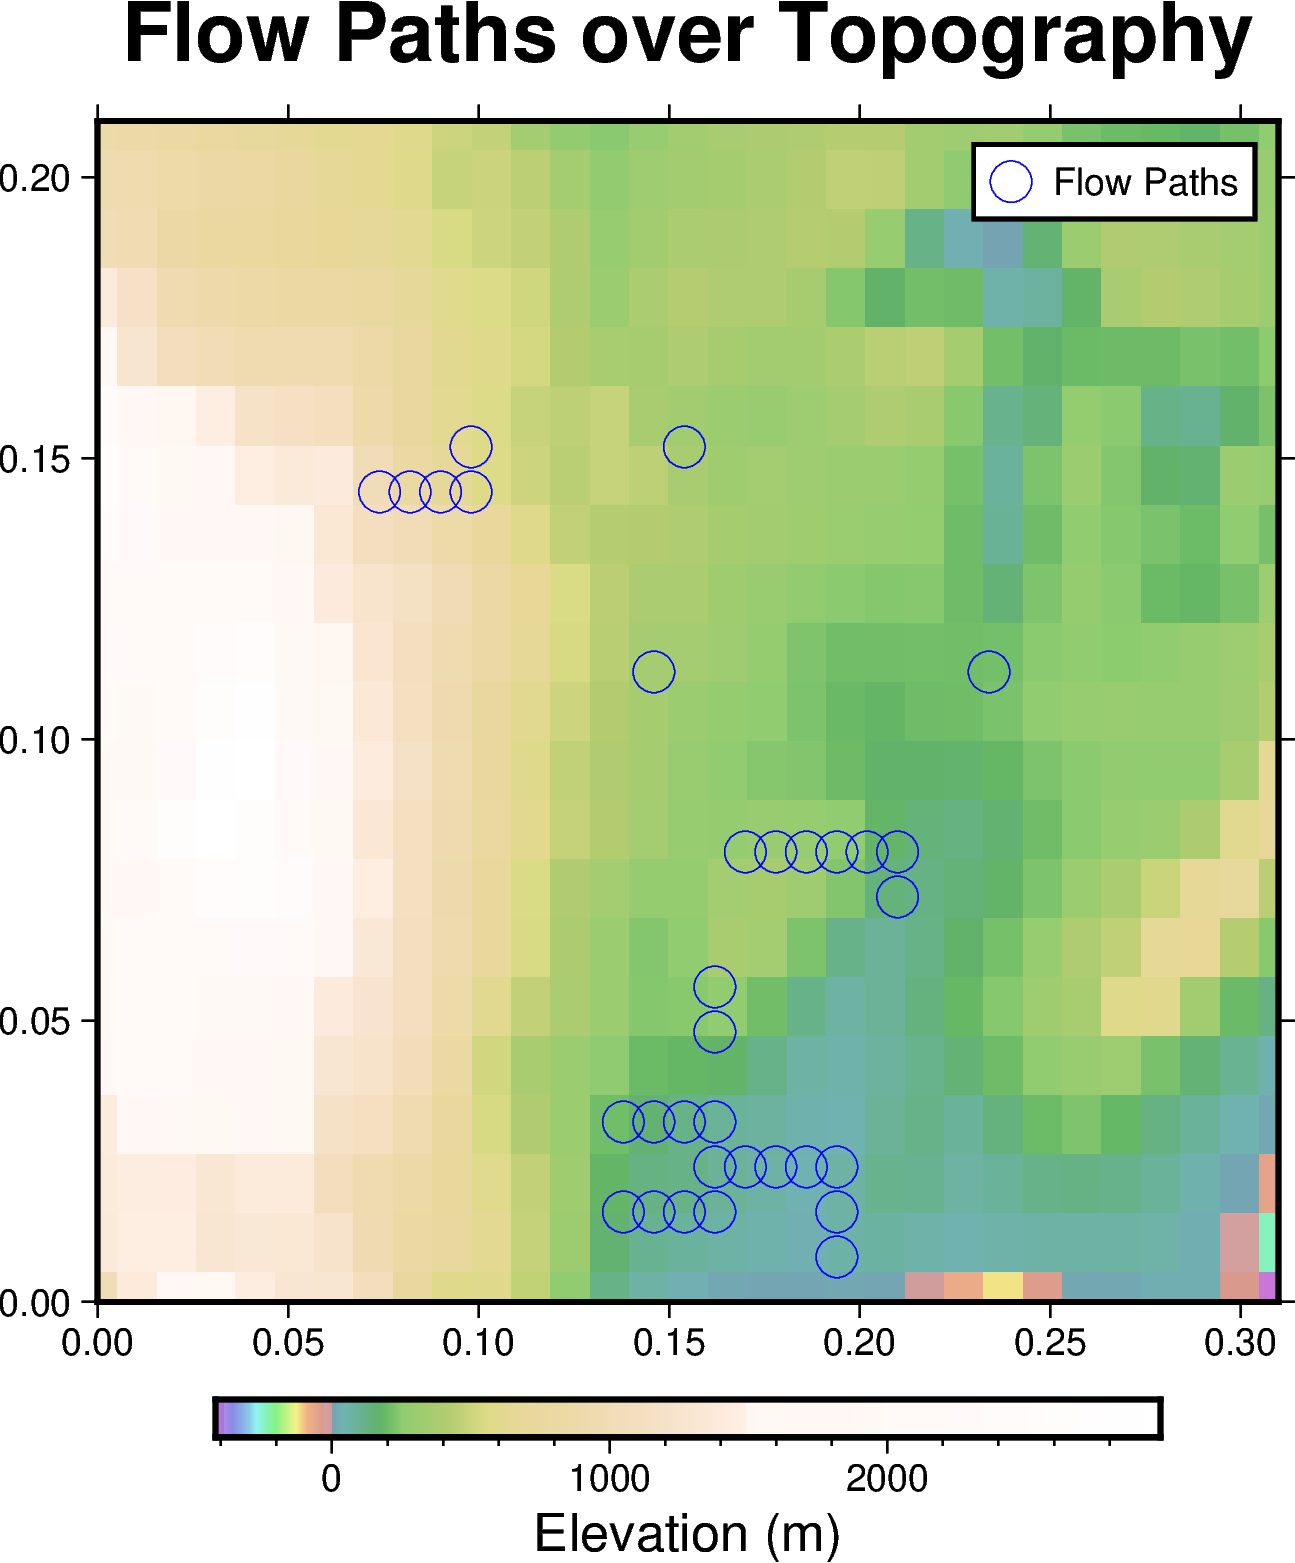

In [107]:
#Define top 5% of drainage area as major streams
threshold = np.percentile(drainage_area, 95)
stream_nodes = drainage_area > threshold

#Extract node coordinates for flow paths
#Reposition because grid coordinates are not the same as return values from stream_nodes
stream_x = .008*mg.node_x[stream_nodes]+0.05
stream_y = .008*mg.node_y[stream_nodes]

#Visualize flow paths on topography
fig = pygmt.Figure()
fig.grdimage(
    grid=grid,
    region=region,
    projection="X10c/10c",
    cmap="topo",
    frame=["a", "WSen+tFlow Paths over Topography"]
)
fig.plot(
    x=stream_x, y=stream_y, style="c.35c", pen="blue", label="Flow Paths"
)
fig.legend()
fig.colorbar(frame="af+lElevation (m)")
fig.show()

For interactive modeling, we will define our function <code>run_erosion</code>. Passing through the erodability factor <code>K_sp</code>, this function will provide us visualization of different values of <code>K_sp</code> on erosion.

In [87]:
#Interactive erosion modeling function
def run_erosion(K_sp):
    #Reset DEM to original state
    mg.at_node["topographic__elevation"][:] = z.flatten()

    #Define constants
    uplift_rate = 0.1  #Tectonic lift rate
    n_steps = 50  #Number of steps

    #Modify terrain based on tectonic uplift and depressions at drainage area
    for _ in range(n_steps):
        mg.at_node["topographic__elevation"][mg.core_nodes] += uplift_rate
        fa.run_one_step()
        mg.at_node["topographic__elevation"][mg.core_nodes] -= (
            10 * K_sp * mg.at_node["drainage_area"][mg.core_nodes]
        )

    #Plot eroded terrain
    eroded_elevation = mg.at_node["topographic__elevation"].reshape((nrows, ncols))
    eroded_elevation_grid = xr.DataArray(
        eroded_elevation * 10,
        coords={
            "lon": np.linspace(region[0], region[1], ncols),
            "lat": np.linspace(region[2], region[3], nrows),
        },
        dims=["lat", "lon"],
    )

    fig = pygmt.Figure()
    fig.grdimage(
        grid=eroded_elevation_grid,
        region=region,
        projection="X10c/10c",
        cmap="plasma",
        #cmap_limits=[min_value, max_value],
        frame=["a", f"WSen+tEroded Topography (K_sp={K_sp})"]
    )
    fig.colorbar(frame="af+lElevation (m)")
    fig.show()


Run <code>run_ersion</code> and visualize results

In [88]:
#Add interactive slider for erosion modeling
interact(
    run_erosion,
    K_sp=FloatSlider(value=1e-3, min=1e-5, max=1e-1, step=1e-6, description="K_sp"),
)

interactive(children=(FloatSlider(value=0.001, description='K_sp', max=0.1, min=1e-05, step=1e-06), Output()),…

<function __main__.run_erosion(K_sp)>